In [1]:
#check if there is a compatible GPU
from torch.cuda import is_available, get_device_name

if is_available():
    print(f"The environment has a compatible GPU ({get_device_name()}) available.")
else:
    print(f"The environment does NOT have a compatible GPU model available.")

The environment does NOT have a compatible GPU model available.


In [2]:
#import modules
from numpy import clip
from matplotlib import pyplot as plt
from torch import Tensor

#function to plot images
def imshow(inp: Tensor) -> None:
    """Imshow for Tensor."""
    inp = inp.cpu().numpy()
    inp = inp.transpose((1, 2, 0))
    mean = array([0.485, 0.456, 0.406])
    std = array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

# Load the Dataset

In [3]:
"""
Hotdog/Not Hotdog training data.
"""
import os
from typing import Tuple
from zipfile import ZipFile
from PIL import Image

from numpy import array
from pandas import read_csv
from requests import get
from torch.utils.data import Dataset

#this class will download the dataset
#transform it(based on parameters we input)
#match the images in the dataset to a label(hotdog or nothotdog)
class HotDogDataset(Dataset):
    """
    Child class of torch.utils.data.Dataset.

    This is a wrapper for mapping from hotdog/not hotdog images to the target.
    """

    def __init__(self, dir_name, transform=None) -> None:
        """
        Initialise a HotdogDataset class

        :param dir_name: The name of the folder holding the data.
        :param transform:
        """
        self.transform = transform
        # Download, save and extract the data if needed.
        if not os.path.isdir(os.path.join(os.getcwd(), f"{dir_name}")):
            r = get(f"https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/hotdog-not-hotdog/data/{dir_name}.zip")
            f = open(os.path.join(os.getcwd(), f"{dir_name}.zip"), mode="wb+")
            f.write(r.content)
            f.close()
            with ZipFile(os.path.join(os.getcwd(), f"{dir_name}.zip"), 'r') as zip_ref:
                zip_ref.extractall("./")
                zip_ref.close()
        # Load the metadata.
        self.data = read_csv(os.path.join(os.getcwd(), dir_name, f"{dir_name}_labels.csv"))
        # Number of classes.
        self.n_classes = len(self.data['y'].unique())

    def __len__(self) -> int:
        """
        :return: The length of the training/testing dataset.
        """
        return len(self.data)

    def __getitem__(self, idx) -> Tuple[array, str]:
        """
        Return the input and target at a specific index of the dataset.

        :param idx: The index of the data to be returned.
        :return: Key-value pair at the specified index.
        """
        # Open the corresponding Image.
        image = Image.open(os.path.join(os.getcwd(), self.data.loc[idx, 'file_name']))
        # Retrieve the label.
        y = self.data.loc[idx, 'y']
        # Transform the image if necessary.
        if self.transform is not None:
            image_ = self.transform(image)
            image.close()
        else:
            image_ = array(image)
            image.close()
        return image_, y

# Create a training framework

In [4]:
"""
A training framework for classification tasks.
"""

from copy import deepcopy
from typing import List, Tuple
from os.path import join
from os import getcwd

from matplotlib.pyplot import subplots, show
from numpy import sum
from torch import argmax, device, cuda, save, load
from torch.nn import Module
from torch.nn.functional import softmax
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

#this class will train, validate and test the model
#this framework provides a convenient method to train our model
#with the desired hyperparameters and view the output and training metrics
class ClassificationModelTrainer:

    def __init__(self,
                 model: Module,
                 training_set: Dataset,
                 validation_set: Dataset,
                 batch_size: int,
                 minimising_criterion: _Loss,
                 optimiser: Optimizer) -> None:
        """
        Initialise a classification model training module.

        :param model: The model to train.
        :param training_set: The set of training data.
        :param validation_set: The set of validation data.
        :param batch_size: The batch size for training.
        :param minimising_criterion: The loss function.
        :param optimiser: The algorithm to perform minimisation task.
        """
        self._device = device("cuda:0" if cuda.is_available() else "cpu")
        self._model = model.to(self._device)
        self._train_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
        self._validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=True)
        self._minimising_criterion = minimising_criterion
        self._optimiser = optimiser
        self.training_loss = []
        self.validation_acc = []

    def get_model(self) -> Module:
        """
        Getter function for model.

        :return: Return the trained model.
        """
        return self._model

    def train_model(self, n_epochs) -> None:
        """
        Perform the model training.

        :param n_epochs: The number of training epochs to run.
        """
        # Setup the progress bar.
        pbar = tqdm(total=n_epochs * (len(self._train_loader) + len(self._validation_loader)))
        pbar.set_postfix({
            "Training Loss": "Not yet available" if len(self.training_loss) == 0 else self.training_loss[-1],
            "Validation Accuracy": "Not yet available" if len(self.validation_acc) == 0 else self.validation_acc[-1],
            "Epoch": 1
        })
        # Training through the epochs.
        for epoch in range(n_epochs):
            loss_sublist = []
            # Training Process
            for x, y in self._train_loader:
                x, y = x.to(self._device), y.to(self._device)
                self._model.train()
                z = self._model(x)
                loss = self._minimising_criterion(z, y)
                loss_sublist.append(loss.data.item())
                loss.backward()
                self._optimiser.step()
                self._optimiser.zero_grad()
                pbar.update()
            self.training_loss.append(sum(loss_sublist))
            # Validation Process
            correct = 0
            n_test = 0
            for x_test, y_test in self._validation_loader:
                x_test, y_test = x_test.to(self._device), y_test.to(self._device)
                self._model.eval()
                z = softmax(self._model(x_test), dim=1)
                y_hat = argmax(z.data, dim=1)
                correct += (y_hat == y_test).sum().item()
                n_test += y_hat.shape[0]
                pbar.update()
            accuracy = correct / n_test
            self.validation_acc.append(accuracy)
            pbar.set_postfix({
                "Training Loss": self.training_loss[-1],
                "Validation Accuracy": accuracy,
                "Epoch": epoch + 2
            })
        pbar.set_postfix({
            "Training Loss": self.training_loss[-1],
            "Validation Accuracy": self.validation_acc[-1],
            "Epoch": n_epochs
        })

    def plot_training_stat(self):
        """
        This function plots the training statistics the model trainer collected 
        throughout the training process. Namely, they are

        - Total training loss versus Iterations, and
        - Validation Accuracy versus Iterations.

        The two statistics are placed in the same plot, respectively in red and
        blue.
        """
        # Plot Total training loss versus Iterations
        fig, ax1 = subplots()
        color = 'tab:red'
        ax1.plot(self.training_loss, color=color)
        ax1.set_xlabel('Iterations', color="black")
        ax1.set_ylabel('Total Training Loss', color=color)
        ax1.set_ylim(bottom = 0)
        ax1.tick_params(axis='y', color=color)
        # Plot Validation Accuracy versus Iterations
        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Validation Accuracy', color=color)
        ax2.plot(self.validation_acc, color=color)
        ax2.tick_params(axis='y', color=color)
        ax2.set_ylim(0, 1)
        fig.tight_layout()
        show()

    def test(self, testing_data: Dataset) -> float:
        """
        This function tests the model's performance on a given dataset.

        :param testing_data: The dataset to perform testing upon.
        :return: Model's accuracy on the given testing data.
        """
        _class = ["Hot dog", "Not hot dog"]
        j = 0
        total = 0
        print("Here are a list of inaccurately classified results:")
        for x, y in DataLoader(dataset=testing_data, batch_size=1, shuffle=True):
            x, y = x.to(self._device), y.to(self._device)
            predicted = argmax(softmax(self._model(x.to(self._device)), dim=1), dim=1)
            if predicted != y:
                j += 1
                print(f"Actual: {_class[y.item()]}\t\tPredicted: {_class[predicted.item()]}")
                imshow(x[0])
            total += 1
        return 100 - 100 * j / total

    def dump_to(self, file_name: str) -> None:
        """
        This function dumps the trained model. 

        :param file_name: The directory to save state files.
        """
        save_path = join(getcwd(), file_name)
        save({"model_params": self._model.state_dict(),
              "optimiser_stats": self._optimiser.state_dict(),
              "acc": self.validation_acc,
              "loss": self.training_loss
              }, save_path)
        
    def load_from(self, path: str) -> None:
        """
        This function loads the dumped file back to the training framework
​
        :param path: The path to the dumped file.
        """        
        state_dict = load(path, map_location=self._device)
        self._model.load_state_dict(state_dict["model_params"])
        self._optimiser.load_state_dict(state_dict["optimiser_stats"])
        self.validation_acc = state_dict["acc"]
        self.training_loss = state_dict["loss"]

# Transform the dataset

In [5]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
#create resized copies of the images
#rotate and horizontally flip them
#convert the images to a tensor and normalize its image channels
composed = transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(degrees=5),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
                               ])

In [6]:
dataset_full = HotDogDataset("hotdognothotdogfull", transform = composed)

In [7]:
from torch.utils.data import random_split
from torch import manual_seed

manual_seed(0)
#60% of our dataset for training
#25% of our dataset for validating
#15% of our dataset for testing
training_size = int(len(dataset_full) * 0.6)
validation_size = int(len(dataset_full) * 0.2)
test_size = len(dataset_full) - training_size - validation_size
training_set, validation_set, test_set = random_split(dataset=dataset_full, lengths=(training_size, validation_size, test_size))

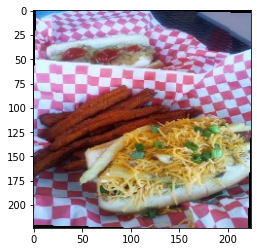

In [8]:
imshow(training_set[0][0])

# Set Hyperparameters

In [9]:
# Batch size: train set  
batch_size = 50

# Learning rate  
lr = 5e-3

# Number epochs 
n_epochs = 25

# Load the model

In [10]:
from torchvision import models

model = models.resnet18(pretrained = True)

In [11]:
#the original network was designed for classifying the image to 1000 different classes
#since we have less classes
#we will replace the final layer 
#to the number of neurons we have
from torch.nn import Linear

for param in model.parameters():
    param.requires_grad = False

# Next, we set `n_classes` to the number of classes we have. 
# Recall that we have two classes: "hotdog" and "not hotdog".
n_classes = dataset_full.n_classes

# Now that we have those parameters set, we can replace the output layer, 
# `model.fc` of the neural network, with a `nn.Linear` object to classify 
# `n_classes`'s different classes. For the first parameter, known as **in_features**, 
# we input 512 because the second last hidden layer of the neural network 
# has 512 neurons.
model.fc = Linear(512, n_classes)

In [12]:
from torch.nn import CrossEntropyLoss

#find a model with a lower loss function
criterion = CrossEntropyLoss()

In [13]:
from torch.optim import Adam

#The adam optimizer gets parameters that 
#will minimize the loss function
optimizer = Adam(model.parameters(), lr = lr)

In [14]:
#set up the training framework
trainer = ClassificationModelTrainer(model,
                                     training_set,
                                     validation_set,
                                     batch_size,
                                     criterion,
                                     optimizer)

In [15]:
r = get(f"https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/build-a-hotdog-not-hotdog-classifier-guided-project/twenty-five-iters.pt")
f = open(os.path.join(os.getcwd(), "./twenty-five-iters.pt"), mode="wb+")
f.write(r.content)
f.close()

trainer.load_from("./twenty-five-iters.pt")
trainer.train_model(n_epochs = 4)

100%|████████████████████████████| 64/64 [05:22<00:00,  5.03s/it, Training Loss=1.7, Validation Accuracy=0.92, Epoch=4]


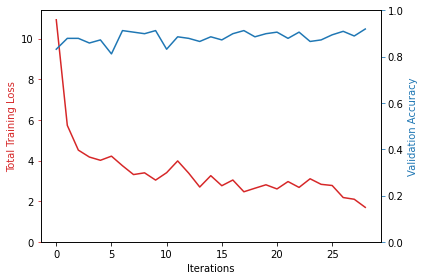

In [16]:
trainer.plot_training_stat()

Here are a list of inaccurately classified results:
Actual: Hot dog		Predicted: Not hot dog


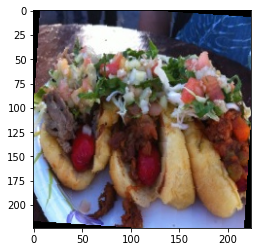

Actual: Hot dog		Predicted: Not hot dog


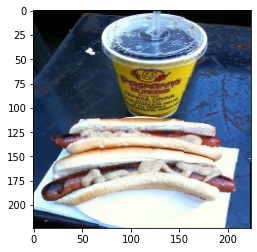

Actual: Hot dog		Predicted: Not hot dog


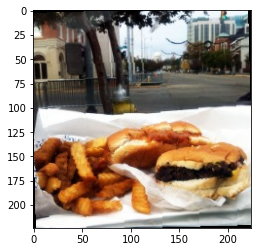

Actual: Hot dog		Predicted: Not hot dog


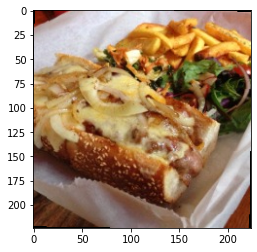

Actual: Hot dog		Predicted: Not hot dog


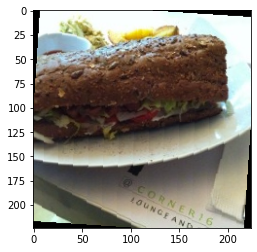

Actual: Not hot dog		Predicted: Hot dog


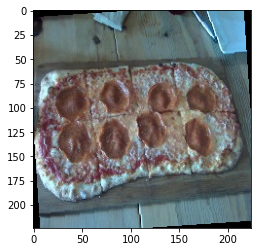

Actual: Hot dog		Predicted: Not hot dog


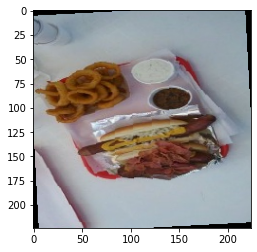

Actual: Hot dog		Predicted: Not hot dog


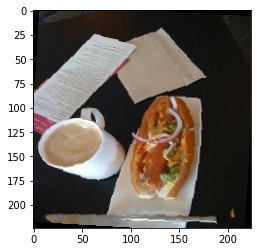

Actual: Not hot dog		Predicted: Hot dog


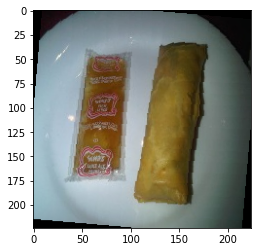

Actual: Hot dog		Predicted: Not hot dog


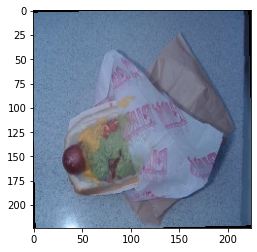

Actual: Hot dog		Predicted: Not hot dog


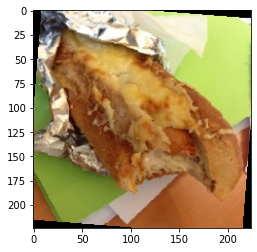

Actual: Hot dog		Predicted: Not hot dog


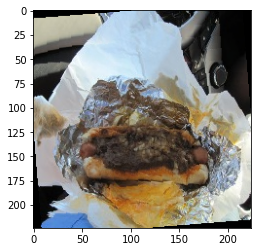

Actual: Not hot dog		Predicted: Hot dog


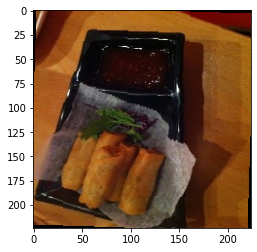

Actual: Not hot dog		Predicted: Hot dog


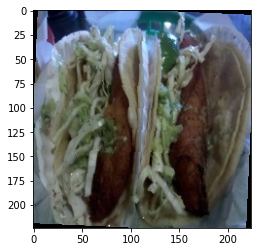

Actual: Not hot dog		Predicted: Hot dog


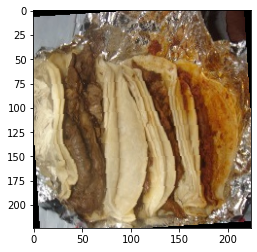

Actual: Hot dog		Predicted: Not hot dog


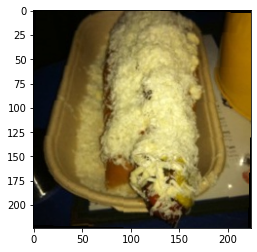

Actual: Hot dog		Predicted: Not hot dog


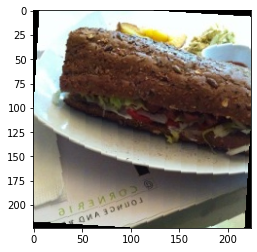

Actual: Hot dog		Predicted: Not hot dog


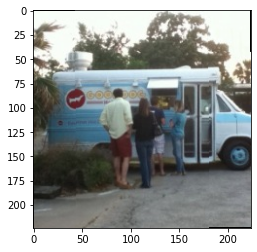

Actual: Hot dog		Predicted: Not hot dog


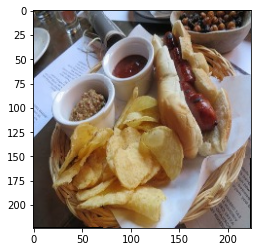

Actual: Not hot dog		Predicted: Hot dog


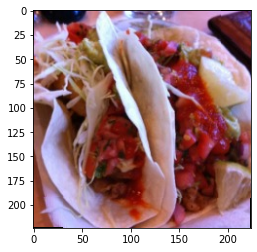

Actual: Hot dog		Predicted: Not hot dog


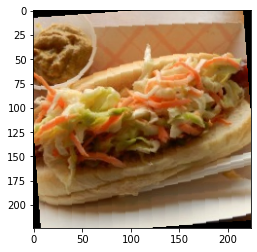

Actual: Hot dog		Predicted: Not hot dog


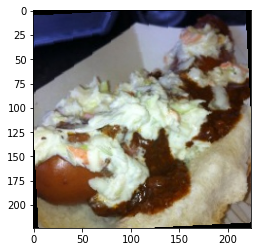

Actual: Not hot dog		Predicted: Hot dog


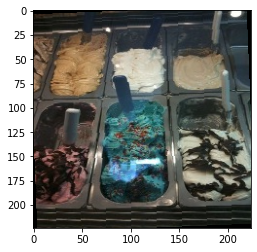

In [17]:
accuracy = trainer.test(test_set)

In [18]:
print(f"The model reached an accuracy rate of {accuracy:.2f}% on images it has never seen before.")

The model reached an accuracy rate of 88.50% on images it has never seen before.
